In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw
import albumentations as A
import json
import shutil

In [2]:
# Image

def get_bbox(mask, plot=False):

    transform = A.Resize(800, 800)

    mask = np.array(mask)

    # BBOX

    y_shape, x_shape = mask.shape

    rows, cols = np.where(mask != 0)
    y_min, y_max = rows.min()/y_shape, rows.max()/y_shape
    x_min, x_max = cols.min()/x_shape, cols.max()/x_shape

    h = y_max - y_min
    w = x_max - x_min
    bbox = (x_min, y_min, w, h)
    
    transformed_data = transform(image=mask, bboxes=[bbox])
    bbox = transformed_data['bboxes'][0]
    bbox = np.array(bbox) * 800
    bbox = np.round(bbox, 2)
    x_min, y_min, w, h = bbox
    area = np.round(w * h, 2)
    print(bbox)
    
    return bbox, area

In [3]:
root = os.path.join('CBIS-DDSM', 'CBIS-JPG', 'TRAIN')
root_crops = os.path.join(root, 'CROPS')
root_masks = os.path.join(root, 'MASKS')
root_images = os.path.join(root, 'IMAGES')

root_resized_images = os.path.join('CBIS-COCO', "test")

In [4]:
annotations = {
    'categories': [
        {
            'id': 0,
            'name': 'Mass',
            'supercategory': 'none'
        }
    ],
    'images': [],
    'annotations': []
}

if os.path.exists(root_resized_images):
    shutil.rmtree(root_resized_images)
os.mkdir(root_resized_images)

# IMAGES

images = os.listdir(root_images)
image_cache = {}

for image_id, image_name in enumerate(images):
    # Original Image
    image = Image.open(os.path.join(root_images, image_name))
    image = np.array(image)
    
    # Transformed Image
    transform = A.Resize(800, 800)
    transformed_data = transform(image=image)
    resized_image = transformed_data['image']
    resized_image = Image.fromarray(resized_image)
    resized_image.save(os.path.join(root_resized_images, image_name))
    
    # Image Annotations
    image_annotation = {
        "id": image_id,
        "file_name": image_name,
        "height": 800,
        "width": 800,
    }
    annotations['images'].append(image_annotation)
    image_cache[image_name] = image_annotation
    

# BBOXES

crops = os.listdir(root_crops)

for crop_id, crop_name in enumerate(crops):    
    # Retrieve Image Annotation
    image_name = crop_name.split('_')
    image_name = '_'.join(image_name[:-1]) + '.jpg'
    image_annotation = image_cache[image_name]
    
    # Extract BBOX with resize
    mask = Image.open(os.path.join(root_masks, crop_name))
    bbox, area = get_bbox(mask, plot=False)
    
    # Crop Annotations
    crop_annotation = {
        "id": crop_id,
        "image_id": image_annotation['id'],
        "category_id": 0,
        "bbox": list(bbox),
        "area": area,
    }
    annotations['annotations'].append(crop_annotation)
    
# Save Annotations
with open(os.path.join(root_resized_images, '_annotations.coco.json'), 'w') as f:
    json.dump(annotations, f, indent=4)

[645.95 396.33 129.97  67.34]
[452.93 322.08 120.6   48.71]
[560.16 240.78 220.71 170.74]


In [5]:
import sys
sys.path.insert(0,'../DETR/')
from detr_config import Config
Config.set_local_settings()
Config.DATASET = 'CBIS-COCO'

from detr_factory import DETRFactory
from detr_file_manager import FileManager
from detr_data_source import DataSource
from detr_detection import plot_annotations

hyperparameters = ('D-DETR', 100, 6)
detr_factory = DETRFactory(*hyperparameters)
file_manager = FileManager(detr_factory)
data_source = DataSource(detr_factory, file_manager)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [6]:
dataset = data_source.get_test_dataset()
dataset

Loading Annotations from:  CBIS-COCO\test\_annotations.coco.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Dataset InBreastDataset
    Number of datapoints: 3
    Root location: CBIS-COCO\test

[{'id': 2, 'image_id': 2, 'category_id': 0, 'bbox': [560.16, 240.78, 220.71, 170.74], 'area': 37684.03}]
{'size': tensor([800, 800]), 'image_id': tensor([2]), 'class_labels': tensor([0]), 'boxes': tensor([[0.8381, 0.4077, 0.2759, 0.2134]]), 'area': tensor([37684.0312]), 'iscrowd': tensor([0]), 'orig_size': tensor([800, 800])}


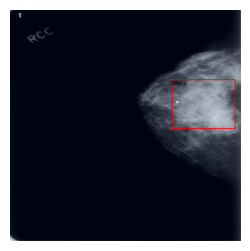

In [7]:
image, annotations = dataset.__getitem__(2)
plot_annotations(image, annotations, {0:'Mass'})